# How would ReproNim do that?

## Volume 4: Manage local FreeSurfer results

This is the companion Jupyter notebook to *How would ReproNim do that Volume 4*.

### Problem statement

I have performed a FreeSurfer analysis locally. I hear that ReproNim has some cool tools to manage the results of such an analysis. What are they and how do I do it?

In this example I’ve run FreeSurfer 6.0 on a set of 17 ABIDE subjects. The FreeSurfer $SUBJECTS_DIR is subjects/ and is stripped down to contain only stats/aseg.stats, stats/lh.aparc.stats, stats/rh.aparc.stats, and scripts/build-stamp.txt for each subject.

### In theory

Given the FreeSurfer results, we will use segstats_jsonld to create a NeuroImaging Data Model (NIDM) semantically marked up version of the volumetric data files. The semantic markup makes the FreeSurfer results self describing in that each result is associated with a concept that completely describes the result (type of measure (e.g. volume), structure (e.g. caudate nucleus), etc.). Complete semantic description of results makes integration of results from disparate sources easier. Once we’ve created the NIDM version of the FreeSurfer results, we can query our results using PyNIDM, and, more importantly, we can merge local results with publicly available results and query across these combined data representations.

See the static document (LINK) for instructions on installing segstats_jsonld, which provides the programs used below.

Run asegstats2nidm on a single subject in order to express local FreeSurfer results in NIDM.

In [1]:
mkdir single_subject

In [2]:
segstats2nidm -add_de -s `pwd`/subjects/Olin_0050107 -o `pwd`/single_subject

Creating NIDM file...
Writing NIDM file...
Creating NIDM file...
Writing NIDM file...
Creating NIDM file...
Writing NIDM file...


This takes the aseg.stats file for my particular subject (Olin_0050107) and generates the following files:

In [3]:
ls single_subject

aseg_nidm.ttl		lh.aparc_nidm.ttl	rh.aparc_nidm.ttl


These files contain data expressed as NIDM in Turtle format (.ttl).

Examine a NIDM file to see what it has using ‘PyNIDM query’. PyNIDM is installed with segstats_jsonld.

In [4]:
pynidm query -nl `pwd`/single_subject/aseg_nidm.ttl -bv -o `pwd`/single_query_results.txt

In [31]:
cat `pwd`/single_query_results.txt

cat /Users/ch/lib/umms/repronim/how-would-repronim-4/single_query_results.txt


So that was one subject, but I have a set of 17 FreeSurfer subjects.  Let’s make a NIDM representation of this complete set.

In [6]:
mkdir all_subjects

In [32]:
for subject_dir in subjects/*
do
    subject=`basename $subject_dir`
    echo $subject
    mkdir all_subjects/$subject
    segstats2nidm -add_de -s `pwd`/$subject_dir -o `pwd`/all_subjects/$subject
    echo
done
echo done

for subject_dir in subjects/CMU_0050646 subjects/Caltech_51478 subjects/KKI_0050778 subjects/Leuven_0050691 subjects/MaxMun_51348 subjects/NYU_0050965 subjects/OHSU_0050142 subjects/Olin_0050107 subjects/Pitt_50014 subjects/SBL_51556 subjects/SDSU_0050185 subjects/Stanford_0051168 subjects/Trinity_0050240 subjects/UCLA_0051210 subjects/UM_0050404 subjects/USM_50470 subjects/Yale_0050559
bash: syntax error near unexpected token `do'
Yale_0050559
mkdir: all_subjects/Yale_0050559: File exists
Creating NIDM file...
Writing NIDM file...
Creating NIDM file...
Writing NIDM file...
Creating NIDM file...
Writing NIDM file...

bash: syntax error near unexpected token `done'
done


This results in in a directory (all_subjects) with subdirectories for each subject (CMU_0050646, Caltech_51478, etc.) which contain the corresponding aseg_nidm.ttl, lh.aparc_nidm.ttl, and rh.aparc_nidm.ttl files.

It is unwieldy to work with many separate sets of files, so we can combine the relevant .ttl files into one. For the examples that follow, we will only need the segmentation results, so we concatenate the aseg NIDM files from each of the subjects into one file.  pynidm requires the input files to be specified as a comma-separated list, so we create that first.

In [8]:
aseg_list=`echo all_subjects/*/aseg_nidm.ttl | tr ' ' ,`

In [9]:
pynidm concat -nl $aseg_list -o all_subjects/all_aseg.ttl

We can now query this combined file for various content (remember that all this file has is the regional volumes per subject). First, let's just look at the whole file for brain volumes (-bv):

In [10]:
pynidm query -nl all_subjects/all_aseg.ttl -bv -o all_query_results.txt

In [33]:
cat all_query_results.txt

cat all_query_results.txt


Next, we can ask for a specific brain structure (i.e. Hippocampus) by providing the appropriate SPARQL query: 

In [12]:
pynidm query -nl all_subjects/all_aseg.ttl -q hippocampus_query.sparql -o all_hippocampus_results.txt

In [34]:
cat all_hippocampus_results.txt

cat all_hippocampus_results.txt


This is my local NIDM "pool" of FreeSurfer data from this particular study.

It would be more useful if I can include my demographics and other clinical/behavioral variables, so we add demographics.

For this example, I have my demographics (age (in years), sex, and group) in a .csv file (demographics.csv). I want to express this data in the  NIDM file containing my freesurfer data (demographics.ttl) so that it can be queried and used for analysis.  I have two options: I can use csv2nidm and choose to add the demographics data to an existing NIDM file or I can run csv2nidm without adding to an existing NIDM file and use `pynidm merge -s` later to merge NIDM files by subject ID.

In this case we do the latter.  The command to run is:

    csv2nidm -csv demographics.csv -out demographics.ttl

Because running csv2nidm is an interactive task that requires careful attention to detail and an account and API key for InterLex, this has been run in advance and demographics.ttl has already been generated.  See the static document (LINK) for an example of how csv2nidm is run.

At this point you have two separate NIDM files, one with demographics data and one with FreeSurfer data.  Let’s merge both together by the subject identifiers.

In [14]:
pynidm merge -nl demographics.ttl,all_subjects/all_aseg.ttl -s -o demog_aseg.ttl

Now demog_aseg.ttl has both your demographics data and FreeSurfer brain volumes.

Now that we’ve merged our demographics data with our existing FreeSurfer NIDM file, we can query this combined file get the hippocampus volumes and subject ages.

First we need to query for the project identifier in the NIDM file.

In [15]:
pynidm query -nl demog_aseg.ttl -u /projects

UUID
------------------------------------
a3814f98-8993-11ea-9534-f01898563600


Next let’s find out what we have available for hippocampus statistics.

In [16]:
pynidm query -nl demog_aseg.ttl -u /projects/a3814f98-8993-11ea-9534-f01898563600 | grep Hippo

fs_003342           Left-Hippocampus NVoxels
fs_003343           Left-Hippocampus Volume_mm3 (mm^3)
fs_003347           Left-Hippocampus normMax (MR)
fs_003344           Left-Hippocampus normMean (MR)
fs_003346           Left-Hippocampus normMin (MR)
fs_003348           Left-Hippocampus normRange (MR)
fs_003345           Left-Hippocampus normStdDev (MR)
fs_003447           Right-Hippocampus NVoxels
fs_003448           Right-Hippocampus Volume_mm3 (mm^3)
fs_003452           Right-Hippocampus normMax (MR)
fs_003449           Right-Hippocampus normMean (MR)
fs_003451           Right-Hippocampus normMin (MR)
fs_003453           Right-Hippocampus normRange (MR)
fs_003450           Right-Hippocampus normStdDev (MR)


Of the results above, I’m interested in the left hippocampus volume, which has ID "fs_003343."  Next let’s see if we have age in the dataset.

In [17]:
pynidm query -nl demog_aseg.ttl -u /projects/a3814f98-8993-11ea-9534-f01898563600 | grep age

ImageContrastType                                []
ImageUsageType                                   []
age_2q73ou5         age


It looks like we have a variable for age.  Now let’s query the NIDM file and ask for only these two fields of interest (notice the ?fields= part of the query) and save them to an output file for further analysis.

In [18]:
pynidm query -nl demog_aseg.ttl -u /projects/a3814f98-8993-11ea-9534-f01898563600?fields=age,fs_003343 -o age_hippo_raw.csv

In [35]:
cat age_hippo_raw.csv

cat age_hippo_raw.csv


Note that volumes and ages are on separate lines.  We want to join them so each subject's age and left hippocampus volume are on the same line.

In [20]:
tail -n +2 age_hippo_raw.csv  | paste -d , - - > age_hippo.csv

In [36]:
cat age_hippo.csv

cat age_hippo.csv


Each line contains comma-separated fields, the sixth of which is the left hippocampus volume, and the twelfth of which is the age.

To plot the result, we use a Python script that we can reuse later.

In [22]:
cat plot

#!/usr/bin/env python3

import sys
import matplotlib.pyplot as plt
import pandas as pd

if len(sys.argv) == 3:
    local_file = sys.argv[1]
    adhd200_file = None
    out_file = sys.argv[2]
else:
    local_file = sys.argv[1]
    adhd200_file = sys.argv[2]
    out_file = sys.argv[3]

if not adhd200_file:
    data = pd.read_csv(local_file, header=None)
    plt.plot(data[12], data[5], 'k.')
else:
    data1 = pd.read_csv(local_file, header=None)
    plt.plot(data1[12], data1[5], 'b.', label='Local data')
    data2 = pd.read_csv('adhd200_age_hippo.csv', header=None)
    plt.plot(data2[12], data2[5], 'r.', label='ADHD-200 data')
    plt.legend()

plt.title('Hippocampus volume vs age')
plt.xlabel('Age (years)')
plt.ylabel('Volume (mm$^3$)')
plt.savefig(out_file)

sys.exit(0)

# eof


Plotting the data:

In [23]:
./plot age_hippo.csv vol_vs_age.png

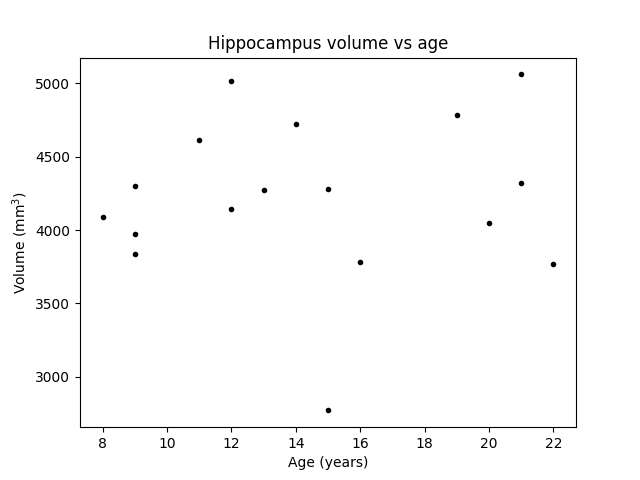

In [24]:
display < vol_vs_age.png

Now we add public data. Let's grab the publicly accessible version of the FreeSurfer analysis of the ADHD-200 data set:

In [25]:
curl -o adhd200_brown.ttl https://raw.githubusercontent.com/dbkeator/simple2_NIDM_examples/master/datasets.datalad.org/adhd200/RawDataBIDS/Brown/nidm.ttl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  760k  100  760k    0     0   778k      0 --:--:-- --:--:-- --:--:--  778k


Now we query the ADHD-200 data as we did our local data above.  The concept for the left hippocampus volume is the same as above, so we use `fields=age,fs_003343` again and just update the project ID.

In [26]:
pynidm query -nl adhd200_brown.ttl -u /projects

UUID
------------------------------------
aedd7d40-6181-11ea-ab38-003ee1ce9545


In [27]:
pynidm query -nl adhd200_brown.ttl -u /projects/aedd7d40-6181-11ea-ab38-003ee1ce9545?fields=age,fs_003343 -o adhd200_age_hippo_raw.csv

In [28]:
tail -n +2 adhd200_age_hippo_raw.csv  | paste -d , - - > adhd200_age_hippo.csv

Now we use our plotting script to plot the local and ADHD-200 data together.

In [29]:
./plot age_hippo.csv adhd200_age_hippo.csv all_vol_vs_age.png

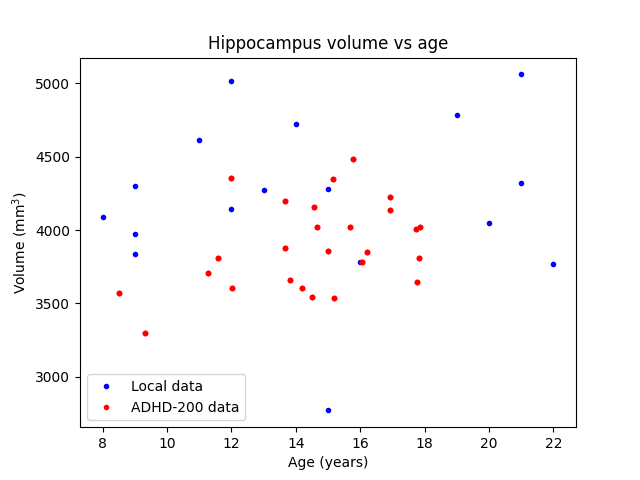

In [30]:
display < all_vol_vs_age.png